In [1]:
src = ""
with open("input.txt", "r") as f:
    src = f.read()
print(src[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [2]:
dictionary = sorted(list(set(src)))
# print dictionary as string
print("".join(dictionary))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [3]:
# encode string to dictionary index
encode = lambda str: [dictionary.index(c) for c in str]
decode  = lambda arr: "".join([dictionary[i] for i in arr])

print(encode('hii there'))
print(decode(encode('hii there')))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [4]:
import numpy as np
block_size = 8
encoded_src = encode(src)
vocab_size = len(dictionary)

# reshpae encoded_src to N * blocksize
data = [encoded_src[i:i+block_size] for i in range(0, len(encoded_src), block_size)][:-2]
data = np.array(data)
data.shape

(139423, 8)

In [5]:
# target is a one-shifted version of data
target = [encoded_src[i+1:i+1+block_size] for i in range(0, len(encoded_src), block_size)][:-2]
target = np.array(target)
target.shape

(139423, 8)

In [6]:
# training data is 70 percent of the data
train_data = data[:int(len(data)*0.7)]
train_target = target[:int(len(target)*0.7)]

# valid data is 30 percent of the data
valid_data = data[int(len(data)*0.7):]
valid_target = target[int(len(target)*0.7):]

print(train_data.shape, train_target.shape)
print(valid_data.shape, valid_target.shape)

(97596, 8) (97596, 8)
(41827, 8) (41827, 8)


In [7]:
import torch

# create dataset (data type is long
train_data = torch.from_numpy(train_data).long()
train_target = torch.from_numpy(train_target).long()
valid_data = torch.from_numpy(valid_data).long()
valid_target = torch.from_numpy(valid_target).long()

train_data

tensor([[18, 47, 56,  ...,  1, 15, 47],
        [58, 47, 64,  ..., 10,  0, 14],
        [43, 44, 53,  ...,  1, 61, 43],
        ...,
        [54, 56, 53,  ..., 57, 57,  7],
        [57, 43, 56,  ..., 56,  6,  1],
        [39,  1, 40,  ..., 50, 47, 44]])

In [8]:
class BigramLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size):
        super(BigramLanguageModel, self).__init__()
        self.logits = torch.nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, x, target):
        x = self.logits(x)
        loss = torch.nn.functional.cross_entropy(x.view(-1, vocab_size), target.view(-1))
        return x, loss
    
    def generate(self, x, length):
        res = []
        for i in range(length):
            x = self.logits(x)
            # sample from multinomial distribution
            x = torch.multinomial(torch.nn.functional.softmax(x.view(-1), dim=0), 1)
            res.append(x)
        return torch.stack(res, dim=0)
model = BigramLanguageModel(vocab_size)

pred = model.generate(torch.tensor([0]), 100)
print(decode(pred.numpy().flatten()))


bn  wZAlZTrE,yypHTmxA
lM;.HVslyFaY;xlOO'F!ZRW3fs$mtiNSVZ3hmnK$wGpgbR!Y'R-OXprEW$j?f CCW'QlSu;vNS;GTk


In [28]:
model = BigramLanguageModel(vocab_size)
pred, loss = model(train_data[:2], train_target[:2])
print(pred.shape, loss)


torch.Size([2, 8, 65]) tensor(4.4438, grad_fn=<NllLossBackward0>)


In [31]:
#training loop
batch_size = 64
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []
val_losses = []

for epoch in range(30):
    for i in range(0, len(train_data), batch_size):
        x = train_data[i:i+batch_size]
        target = train_target[i:i+batch_size]
        optimizer.zero_grad(set_to_none=True)
        pred, loss = model(x, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            val_loss = model(valid_data, valid_target)[1].item()
            print(f"Epoch {epoch} Iter {i} Loss {loss.item()}, valid loss {val_loss}")
            losses.append(loss.item())
            val_losses.append(val_loss)
            # print(decode(pred.numpy().flatten()))


Epoch 0 Iter 0 Loss 2.604656219482422, valid loss 2.550445795059204
Epoch 0 Iter 8000 Loss 2.4726223945617676, valid loss 2.531864881515503
Epoch 0 Iter 16000 Loss 2.3724405765533447, valid loss 2.539384603500366
Epoch 0 Iter 24000 Loss 2.4437637329101562, valid loss 2.5308194160461426
Epoch 0 Iter 32000 Loss 2.426405429840088, valid loss 2.5329678058624268
Epoch 0 Iter 40000 Loss 2.4686450958251953, valid loss 2.545179843902588
Epoch 0 Iter 48000 Loss 2.536198139190674, valid loss 2.543801784515381
Epoch 0 Iter 56000 Loss 2.4402151107788086, valid loss 2.547003984451294
Epoch 0 Iter 64000 Loss 2.574610948562622, valid loss 2.521198034286499
Epoch 0 Iter 72000 Loss 2.4009687900543213, valid loss 2.5248031616210938
Epoch 0 Iter 80000 Loss 2.442500352859497, valid loss 2.5363430976867676
Epoch 0 Iter 88000 Loss 2.450033187866211, valid loss 2.5474236011505127
Epoch 0 Iter 96000 Loss 2.4987008571624756, valid loss 2.5182271003723145
Epoch 1 Iter 0 Loss 2.5753285884857178, valid loss 2.516

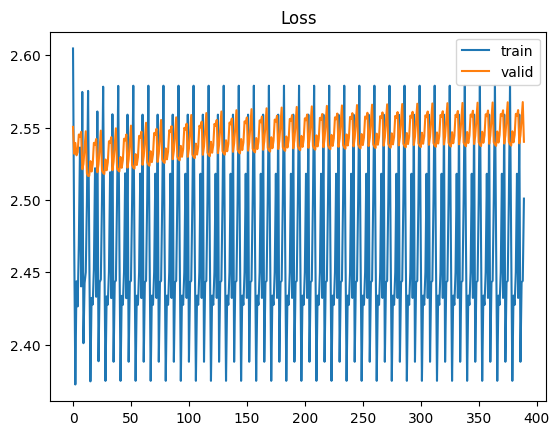

In [32]:
import matplotlib.pyplot as plt
gen_text = lambda model, length: decode(model.generate(torch.tensor([0]), length).numpy().flatten())
# plot moveing average of losses (remove zeros)
#plot text on the right upper corner
plt.title("Loss")
# plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'), label=gen_text(model, 100))
# plt.plot(np.convolve(val_losses, np.ones(100)/100, mode='valid'))
plt.plot(losses, label="train")
plt.plot(val_losses, label="valid")
plt.legend()


In [33]:
print(gen_text(model, 200))

HAl m'sth s inor t m tithend g Thon my aviffaleve, toowbrsthes fous serse,
Tony
Halon
CEOfe t g f beden l atr gloks beseestys s sorals where whorcce h heten, f berend thead, t!
Mare.
F y; a HAncetore 


In [34]:
train_data.shape

torch.Size([97596, 8])

In [55]:
# self attention matrix
import torch.nn. functional as F
wei = torch.zeros((8, 8))
tril = torch.tril(torch.ones(8, 8))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [46]:
x = torch.randn(2, 8, 3) #(B, T, C)
xbow = wei @ x

tensor([[-0.4667, -0.0413, -0.9375],
        [-1.3139, -2.6856, -1.0064],
        [-0.3339, -0.4239, -0.3574],
        [-1.0960,  1.2213,  1.4331],
        [ 0.7483,  0.1539, -0.0616],
        [ 0.3406,  1.0816,  2.4460],
        [ 0.5318,  0.1543,  0.3475],
        [ 0.5813, -0.4829,  0.0697]]) tensor([[-0.4667, -0.0413, -0.9375],
        [-0.8903, -1.3634, -0.9720],
        [-0.7048, -1.0502, -0.7671],
        [-0.8026, -0.4824, -0.2171],
        [-0.4924, -0.3551, -0.1860],
        [-0.3536, -0.1157,  0.2527],
        [-0.2271, -0.0771,  0.2662],
        [-0.1260, -0.1278,  0.2417]])


In [56]:
n_embed =32
class BigramLanguageModelV2(torch.nn.Module):
    def __init__(self, vocab_size, n_embed):
        super(BigramLanguageModel, self).__init__()
        self.logits = torch.nn.Embedding(vocab_size, n_embed)
        self.lm_head = torch.nn.Linear(n_embed, vocab_size)
        
    def forward(self, x, target):
        token_emb = self.logits(x) # (B, T, C)
        x = self.lm_head(token_emb) # (B, T, vocab_size)
        loss = torch.nn.functional.cross_entropy(x.view(-1, vocab_size), target.view(-1)) 
        return x, loss
    
    def generate(self, x, length):
        res = []
        for i in range(length):
            x = self.logits(x)
            # sample from multinomial distribution
            x = torch.multinomial(torch.nn.functional.softmax(x.view(-1), dim=0), 1)
            res.append(x)
        return torch.stack(res, dim=0)